# IS5126 Project (Spotify Slow Burners)

## Table of contents
1) [Introduction, Focial question, audience](#section_1)

2) [Data Retrival and Cleaning](#section_2)

3) [Performing the K-Means to Group Songs by "Type" Based on Music Attributes](#section_3)

4) [Performing the Regression and Predictive Analysis](#section_4)

5) [Causality Analysis](#section_5)

6) [Conclusion](#section_6)

<a id="section_1"></a>
## Introduction

On a worldwide scale, the general population amid Covid-19 display preference to access music rather than own it, resulting in a good performance in music streaming (Hall, 2021;Henderson, 2021). The global prevalence of music streaming addiction exposes music producers to a detailed information database of listening behavior, which can be used as data sources to study popularity (Bender, Gal-Or, and Geylani,2021; Maas and Hagen, 2020). Spotify, the world's largest music streaming service provider, serves as a marketing tool for musicians and music labels, allowing them to promote their songs and reach massive audiences (Iqbal, 2022). Therefore, Spotify not only has data on listening behavior but also maintains a database of song attributes.

### Focal question of the project

The focal question of this project is: 

**What factors contribute to a song being a "slow-burner" within the top-200 charts, or in other words, a long-lasting song in Spotify in the top-200 charts.**

### Literature Review

The initial idea for this research project stemmed from a New York Times article that used the Spotify audio features to illustrate the similarity of summer songs. Music technology companies such as The Echo Nest, ChartMetric, and Next Big Sound have been using data analytics to help artists and labels predict and track a song's success for almost a decade. This problem is referred to as Hit Song Science (HSS) in the Music Information Retrieval (MIR) field. Machine learning is a popular research and industry tool to approach the HSS question. Researchers have used Convolutional Neural Networks and K-Means Clustering to predict pop hits. Both of these studies were engaging and successful, but focused more heavily on the signal-processing involved in audio analysis.

We decided to take the project in a different direction and instead focus on the factors which make a song long lasting. According to the Spotify royalties website, the number of streams are part of a complex calculation to determine the royalties paid to rights-holders or publishers of the track. Hence, music creators (artists, musicians, arrangers, composers), rights-holders and publishers will benefit from an analysis on factors which make a song have staying power in the top charts, hence helping them determine how to produce songs to maximize their potential for becoming long-lasting, hence also giving the greatest return for investment on advertising and publicity. 

The direction of the project is heavily influenced by the analysis of the "half-life" of hit tracks by Blair Fix, which was used to explain the difficulty of music producers to earn money from music. His analysis involved pulling daily data from the Spotify 200 charts, then subsequently calculating the half-life of tracks, defined to be the number of days from the peak number of streams to 50% of its peak. Hence, this project is, in a sense, an extension of the original use of a Spotify's track half-life analysis, to find out what allows a track to have staying power within Spotify which will in turn, benefit the above-mentioned stakeholders in generating long-lasting stream revenue.

https://artists.spotify.com/en/help/article/royalties

https://economicsfromthetopdown.com/2021/06/18/the-half-life-of-a-spotify-hit/#:~:text=Most%20hits%20burn%20briefly.,lucky%20few%20are%20slow%20burners


In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [80]:
df_streams_200 = pd.read_csv('./data/daily-streams-top200.csv')
# Note that the below CSV file was generated from pulling song information 
# from the Spotify API.
df_song_attr = pd.read_csv('./data/spotify200_songAttr.csv')

<a id="section_2"></a>
## Data Retrieval and Cleaning

The daily stream information from the Spotify 200 charts (https://spotifycharts.com/regional/global/daily/latest) are manually downloaded from 1st Jan 2017 to 23rd March 2022. After which, an R-script is run to "concatenate" the daily Spotify 200 CSV files into one gigantic CSV files with the fields described by the data dictionary below:

| Field Name | Data Type | Description |
| --- | --- | --- |
| `position` | int | The position within the top 200 the track is on the given day. |
| `track` | string | The name of the track (song title). |
| `artist` | string | The name of the artist of the track. |
| `streams` | int | The total number of streams of the track on the given day.  |
| `date` | string | The date of the stream / position data (taken from the title of the raw data CSV file).  |
| `track_id` | string | The unique ID of the song (as a primary key) on Spotify in the format of "spotify:track:<\URL ID> |

The below shows the R script used to "concatenate" all the raw data files together.

```
library(magrittr)
library(stringi)
library(hmod)
library(here)
library(lubridate)
library(data.table)

dir = here()
setwd(dir)

# get raw
setwd("./raw")
files = list.files()

# read in files
final = NULL

for(f in files){
  tmp = fread(f)[-1,]
  # col names
  names(tmp) = as.vector(t(tmp[1, ])) %>% tolower()
  # remove col name
  tmp = tmp[-1, ]
  
  # add date
  date = substr(f, 23, 32)
  
  tmp$date = date
  final = rbind(final, tmp)
  print(f)
}

# clean data

# make song id
artist = tolower(final$artist)
song = tolower(final$`track name`)
artist = stri_replace(" ", "_", artist)
song = stri_replace(" ", "_", song)

final$`track_lower` = paste(song, artist, sep="_") 

url_str = final$`url`
url_str = substr(url_str, 32, 53)

final$track_id = paste("spotify:track:", url_str, sep="")

# remove christmas albums
id = grep("christmas", final$`track_lower`)
final = final[-id]
id = grep("santa", final$`track_lower`)
final = final[-id]
id = grep("snow", final$`track_lower`)
final = final[-id]
id = grep("rudolph", final$`track_lower`)
final = final[-id]

names(final)[names(final) == "track name"] <- "track"
final = subset(final, select = -c(url, track_lower))

# export
setwd(dir)
setwd("./final")
fwrite(final, "daily-streams-top200.csv")
```

In [81]:
df_streams_200.head()

,position,track,artist,streams,date,track_id
0,1,Starboy,The Weeknd,3135625,2017-01-01,spotify:track:5aAx2yezTd8zXrkmtKl66Z
1,2,Closer,The Chainsmokers,3015525,2017-01-01,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw
2,3,Let Me Love You,DJ Snake,2545384,2017-01-01,spotify:track:4pdPtRcBmOSQDlJ3Fk945m
3,4,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,2356604,2017-01-01,spotify:track:5knuzwU65gJK7IF5yJsuaW
4,5,One Dance,Drake,2259887,2017-01-01,spotify:track:1xznGGDReH1oQq0xzbwXa3


After which, all unique songs identified by their `track_id` are pulled out and put through the Spotify API. The API will pull the following information of each song from the API, described by the data dictionary below:

| Field Name | Data Type | Description |
| --- | --- | --- |
| `track_id` | string | The unique ID of the song (as a primary key) on Spotify in the format of "spotify:track:<\URL ID> |
| `track` | string | The name of the track (song title) |
| `artist` | string | The name of the artist of the track |
| `genre` | string | The genre of the track obtained from the most common word which appears in the genre of the artist and album. If there is no information, it will be tagged as 'others' |
| `all_markets` | int | 1 denotes if the song is available in all 184 markets Spotify is available in, 0 otherwise |
| `danceability` | float | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| `energy` | float | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. |
| `key` | int | The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
| `loudness` | int | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db. |
| `mode` | int | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
| `speechiness` | int | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| `acousticness` | float | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
| `instrumentalness` | float | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
| `liveness` | float | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
| `valence` | float | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
| `tempo` | float | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |
| `duration_ms` | int | The duration of the track in milliseconds. |
| `time_signature` | int | An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". |
| `grp_class` | int | An indicator whether the artist of the track is a group or solo. 1 indicates the artist which created the track is a group, 0 otherwise. |
| `half_life` | int | The number of days such for a track to drop from its peak stream to 50% of its peak stream. If there is no data on when the 50% peak stream occurs, the half-life is denoted as 0. |

The Spotify API documentation can be found in the following URL: https://spotipy.readthedocs.io/en/2.19.0/

Information regarding the audio features are pulled from the following URL:
https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features

In [82]:
# Get all unique track IDs that exists in this analysis
tracks = np.unique(df_streams_200[['track_id']])
print(tracks)

['spotify:track:000xQL6tZNLJzIrtIgxqSl'
 'spotify:track:003VDDA7J3Xb2ZFlNx7nIZ'
 'spotify:track:003eoIwxETJujVWmNFMoZy' ...
 'spotify:track:7zl7kehxesNEo2pYkKXTSe'
 'spotify:track:7znO2T2deQ7nZUbyxEAMDB'
 'spotify:track:7zxRMhXxJMQCeDDg0rKAVo']


The below is a Python script which performs the pulling of data from each individual song from the Spotify API:

In [83]:
'''
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
from requests.exceptions import ReadTimeout
from collections import defaultdict

###### Authentication needed for Spotify Developer API
cid = '925fc97c95df40759825ef93880104f6'
secret = '28842884e9c1421a9056be25c81691e3'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager, requests_timeout=10, retries=10)
tracks = np.unique(df_streams_200[['track_id']])

song_attrs = []
i = -1
for k in range(int(len(tracks)/500)+1):
    for t in tracks[k*500 : (k+1)*500]:
        try:
            track_info = sp.track(t)
            features = sp.audio_features(t)
        except Exception:
            while(True):
                print("Timeout occured at record", i, "trying again...")
                track_info = sp.track(t)
                features = sp.audio_features(t)
                time.sleep(3)
        row = {}
        row['track_id'] = t
        row['track'] = track_info['name']
        row['artist'] = track_info['artists'][0]['name']
        genres = sp.artist(track_info['artists'][0]['uri'])['genres'] + sp.album(track_info['album']['uri'])['genres']
        temp = defaultdict(int)
        for sub in genres:
            for wrd in sub.split():
                temp[wrd.lower()] += 1
        if not bool(temp):
            row['genre'] = 'others'
        else:
            row['genre'] = max(temp, key=temp.get)
        row['all_markets'] = int(len(track_info['album']['available_markets']) == 184)
        row['danceability'] = features[0]['danceability']
        row['energy'] = features[0]['energy']
        row['key'] = features[0]['key']
        row['loudness'] = features[0]['loudness']
        row['mode'] = features[0]['mode']
        row['speechiness'] = features[0]['speechiness']
        row['acousticness'] = features[0]['acousticness']
        row['instrumentalness'] = features[0]['instrumentalness']
        row['liveness'] = features[0]['liveness']
        row['valence'] = features[0]['valence']
        row['tempo'] = features[0]['tempo']
        row['duration_ms'] = features[0]['duration_ms']
        row['time_signature'] = features[0]['time_signature']
        i+=1
        song_attrs.append(row)
        time.sleep(0.15)
    time.sleep(2)
    print(i)
    
df_song_attr = pd.DataFrame(song_attrs)
df_song_attr.head()
df_song_attr.to_csv('spotify200_songAttr.csv', index = False)
'''

'\nimport spotipy\nfrom spotipy.oauth2 import SpotifyClientCredentials\nimport time\nfrom requests.exceptions import ReadTimeout\nfrom collections import defaultdict\n\n###### Authentication needed for Spotify Developer API\ncid = \'925fc97c95df40759825ef93880104f6\'\nsecret = \'28842884e9c1421a9056be25c81691e3\'\nclient_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)\nsp = spotipy.Spotify(client_credentials_manager = client_credentials_manager, requests_timeout=10, retries=10)\ntracks = np.unique(df_streams_200[[\'track_id\']])\n\nsong_attrs = []\ni = -1\nfor k in range(int(len(tracks)/500)+1):\n    for t in tracks[k*500 : (k+1)*500]:\n        try:\n            track_info = sp.track(t)\n            features = sp.audio_features(t)\n        except Exception:\n            while(True):\n                print("Timeout occured at record", i, "trying again...")\n                track_info = sp.track(t)\n                features = sp.audio_features(t)\n    

In [84]:
'''
df_artist_grpsolo = pd.read_csv('./data/artist_group_solo.csv')
df_artist_grpsolo['grp_class'] = df_artist_grpsolo.apply(lambda x: int(x['group'].lower() == 'group'), axis=1)
df_song_attr = df_song_attr.merge(df_artist_grpsolo[['artist', 'grp_class']], how='left', on='artist')
df_song_attr
'''

"\ndf_artist_grpsolo = pd.read_csv('./data/artist_group_solo.csv')\ndf_artist_grpsolo['grp_class'] = df_artist_grpsolo.apply(lambda x: int(x['group'].lower() == 'group'), axis=1)\ndf_song_attr = df_song_attr.merge(df_artist_grpsolo[['artist', 'grp_class']], how='left', on='artist')\ndf_song_attr\n"

In [85]:
'''
df_song_attr.to_csv('spotify200_songAttr.csv', index = False)
df_song_attr.head()
'''

"\ndf_song_attr.to_csv('spotify200_songAttr.csv', index = False)\ndf_song_attr.head()\n"

In [86]:
# Function to get just the dataframe of the stream and position info of a specific song
def getDFFromSong(trackID):
    df = df_streams_200[df_streams_200['track_id'] == trackID]
    df = df.copy().drop(columns=['track', 'artist', 'track_id'])
    df = df.set_index('date')
    
    row = df_song_attr[df_song_attr['track_id'] == trackID]
    name = row['track'].values[0]
    artist = row['artist'].values[0]
    return name, artist, df

In [87]:
# Test the getDFFromSong function:
# Track-id with "no half-life": spotify:track:003vvx7Niy0yvhvHt4a68B
track, artist, df_temp = getDFFromSong('spotify:track:003vvx7Niy0yvhvHt4a68B')
print('Song:', track, "; From:", artist)
print('Stream and position DF:')
print(df_temp)

Song: Mr. Brightside ; From: The Killers
Stream and position DF:
            position  streams
date                         
2020-08-15       195   650939
2020-08-21       200   670397
2020-08-22       189   674953
2020-08-23       199   584434
2020-08-29       196   667036
...              ...      ...
2022-03-19       161   885126
2022-03-20       154   782210
2022-03-21       162   809124
2022-03-22       161   826648
2022-03-23       158   846686

[355 rows x 2 columns]


### Obtaining the Position and Streaming Half-Life Information from Data

The following functions are defined to obtain the daily stream and position data for each unique song. The half-life of a song is defined to be the number of days the song takes to go from its peak-stream to half its peak stream. 

In [88]:
# Auxiliary function to draw the streams chart since uploaded on Spotify
def drawStreamTrend(trackID):
    track, artist, df = getDFFromSong(trackID)
    num = [x for x in range(df.shape[0])]
    df['num_days'] = num
    start = df.iloc[0].name
    plt.plot(df['num_days'], df['streams'])
    plt.title('No. of Streams for ' + track + ' since ' + df.iloc[0].name)
    plt.xlabel('Days since ' + start)
    plt.ylabel('Streams')
    plt.show()

# Auxiliary function to draw the position chart since uploaded on Spotify
# Positions made negative to more accurately show the position trend (lower the trend number, should be "better")
def drawPositionTrend(trackID):
    track, artist, df = getDFFromSong(trackID)
    num = [x for x in range(df.shape[0])]
    df['num_days'] = num
    start = df.iloc[0].name
    plt.plot(df['num_days'], -1*df['position'])
    plt.title('Position for ' + track + ' since ' + df.iloc[0].name)
    plt.xlabel('Days since ' + start)
    plt.ylabel('Position')
    plt.show()

# Auxiliary function to obtain the peak stream (date and value) and "half-life" (no of days)  
def getStreamPeakAndHalfLife(trackID, onlyHL=True):
    track, artist, df = getDFFromSong(trackID)
    num = [x for x in range(df.shape[0])]
    df['num_days'] = num
    
    max_stream = np.max(df['streams'])
    date_max = df[df['streams']==max_stream].index[0]
    max_day_num = df[df['streams']==max_stream]['num_days'][0]
    
    df_less_half = df.loc[(df['streams'] <= (max_stream /2)) & (df['num_days'] > max_day_num)]
    # If no half-life, record as zero
    if len(df_less_half) == 0:
        half_life = 0
    else:
        half_stream = np.max(df_less_half['streams'])
        half_life = df[df['streams']==half_stream]['num_days'][0] - max_day_num + 1
    
    if onlyHL:
        return half_life
    else: 
        return (max_stream, date_max), half_life

# Auxiliary function to obtain the position statistics within Spotify 200 (best, worst, median)  
def getPosPeakAndHalfLife(trackID):
    track, artist, df = getDFFromSong(trackID)
    best_pos = np.min(df['position'])
    median_pos = np.median(df['position'])
    worst_pos = np.max(df['position'])
    
    return (best_pos, df[df['position']==best_pos].index[0]), (worst_pos, df[df['position']==worst_pos].index[0]), (median_pos, df[df['position']==median_pos].index[0])

As an example, 

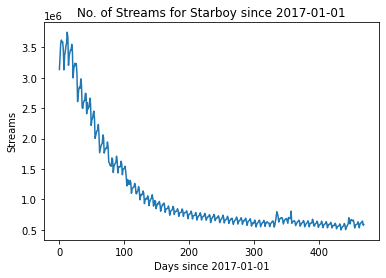

In [89]:
# Track-id with half-life: spotify:track:5aAx2yezTd8zXrkmtKl66Z
# Track-id with "no half-life": spotify:track:003vvx7Niy0yvhvHt4a68B
drawStreamTrend('spotify:track:5aAx2yezTd8zXrkmtKl66Z')

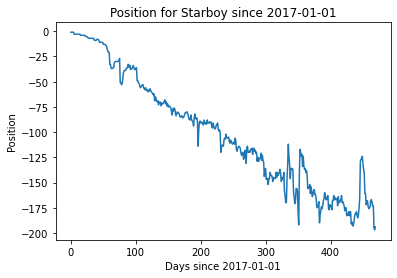

In [90]:
# Track-id with half-life: spotify:track:5aAx2yezTd8zXrkmtKl66Z
# Track-id with "no half-life": spotify:track:003vvx7Niy0yvhvHt4a68B
drawPositionTrend('spotify:track:5aAx2yezTd8zXrkmtKl66Z')

In [91]:
# Track-id with half-life: spotify:track:5aAx2yezTd8zXrkmtKl66Z
# Track-id with "no half-life": spotify:track:003vvx7Niy0yvhvHt4a68B
max_tuple, half_life = getStreamPeakAndHalfLife('spotify:track:5aAx2yezTd8zXrkmtKl66Z', onlyHL=False)
print('Max stream =', max_tuple)
print('Half-life =', half_life)

Max stream = (3747787, '2017-01-13')
Half-life = 64


In [92]:
# Track-id with half-life: spotify:track:5aAx2yezTd8zXrkmtKl66Z
# Track-id with "no half-life": spotify:track:003vvx7Niy0yvhvHt4a68B
best, worst, median = getPosPeakAndHalfLife('spotify:track:5aAx2yezTd8zXrkmtKl66Z')
print('Best Position =', best)
print('Worst Position =', worst)
print('Median Position =', median)

Best Position = (1, '2017-01-01')
Worst Position = (197, '2018-04-25')
Median Position = (106.0, '2017-08-31')


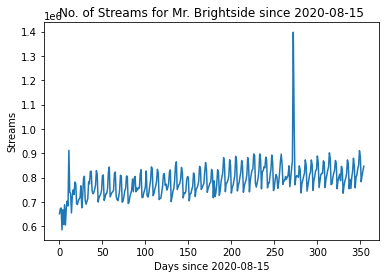

In [93]:
drawStreamTrend('spotify:track:003vvx7Niy0yvhvHt4a68B')

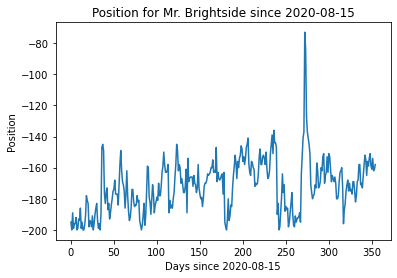

In [94]:
drawPositionTrend('spotify:track:003vvx7Niy0yvhvHt4a68B')

In [95]:
max_tuple, half_life = getStreamPeakAndHalfLife('spotify:track:003vvx7Niy0yvhvHt4a68B', onlyHL=False)
print('Max stream =', max_tuple)
print('Half-life =', half_life)

Max stream = (1397454, '2021-12-31')
Half-life = 0


In [96]:
'''
# Obtain half-life of all entries
df_song_attr['half_life'] = df_song_attr.apply(lambda x: getStreamPeakAndHalfLife(x['track_id']), axis=1)
df_song_attr.to_csv('spotify200_songAttr.csv', index = False)
df_song_attr.head()
'''

"\n# Obtain half-life of all entries\ndf_song_attr['half_life'] = df_song_attr.apply(lambda x: getStreamPeakAndHalfLife(x['track_id']), axis=1)\ndf_song_attr.to_csv('spotify200_songAttr.csv', index = False)\ndf_song_attr.head()\n"

### Half-Life Classifications

After obtaining the numeric half-lifes of each song, to minimise the effect of outliers for the half-lifes, we will introduce a new field to classify the half-life into three different classes, which is described below:

| Field Name | Data Type | Description |
| --- | --- | --- |
| `half_life_class` | int | A song has classification 0 if it is considered a "slow-burner", where its half-life is more than approximately 3 months (90 days). <br> A song has classification 1 if it is considered a "fast-burner", where its half-life is at most approximately 3 months. |

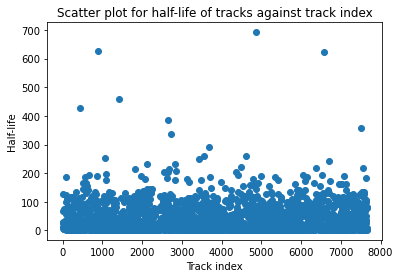

In [97]:
# Remove rows with half_life = 0
df_song_attr_HL_plot = df_song_attr.copy().drop(df_song_attr[df_song_attr['half_life'] == 0].index)

# Scatter plot for half-life to track
plt.title('Scatter plot for half-life of tracks against track index' )
plt.xlabel('Track index')
plt.ylabel('Half-life')
plt.scatter(df_song_attr_HL_plot.index, df_song_attr_HL_plot['half_life'])
plt.show()

In [98]:
# We perform a classification of slow and fast burners.
# The classification will be such that: fast(1) (<= 90 days), slow(0) (> 90 days)
def classifyBurn(half_life):
    if half_life > 90:
        return 0
    else:
        return 1

df_song_attr_HL = df_song_attr.copy().drop(df_song_attr[df_song_attr['half_life'] == 0].index)
df_song_attr_HL['half_life_class'] = df_song_attr_HL.apply(lambda x: classifyBurn(x['half_life']), axis=1)
df_song_attr_HL

,track_id,track,artist,genre,all_markets,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,grp_class,half_life,half_life_class
0,spotify:track:000xQL6tZNLJzIrtIgxqSl,Still Got Time (feat. PARTYNEXTDOOR),ZAYN,pop,1,0.748,0.627,7,-6.029,1,...,0.13100,0.000000,0.0852,0.524,120.963,188491,4,0.0,68,1
5,spotify:track:00Blm7zeNqgYLPtW6zg8cj,One Right Now (with The Weeknd),Post Malone,rap,1,0.687,0.781,1,-4.806,1,...,0.03610,0.000000,0.0755,0.688,97.014,193507,4,0.0,27,1
11,spotify:track:00ko9WaS4jOX1kEk3gvHjf,Hot Shower,Chance the Rapper,rap,1,0.899,0.509,9,-8.040,1,...,0.00157,0.000000,0.0573,0.599,150.001,225924,4,0.0,11,1
12,spotify:track:00lNx0OcTJrS3MKHcB80HY,You Don't Know Me - Radio Edit,Jax Jones,pop,0,0.876,0.669,11,-6.054,0,...,0.16300,0.000000,0.1850,0.682,124.007,213947,4,0.0,30,1
17,spotify:track:017PF4Q3l4DBUiWoXk4OWT,Break My Heart,Dua Lipa,pop,0,0.730,0.729,4,-3.434,0,...,0.16700,0.000001,0.3490,0.467,113.011,221820,4,0.0,127,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7648,spotify:track:7ytR5pFWmSjzHJIeQkgog4,ROCKSTAR (feat. Roddy Ricch),DaBaby,north,1,0.746,0.690,11,-7.956,1,...,0.24700,0.000000,0.1010,0.497,89.977,181733,4,0.0,81,1
7649,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,Broccoli (feat. Lil Yachty),Shelley FKA DRAM,rap,0,0.886,0.525,8,-7.390,1,...,0.23600,0.000000,0.0570,0.708,145.990,225205,4,0.0,79,1
7650,spotify:track:7z4xW9WY86uH3gd1V9pfCM,JUGGERNAUT (feat. Lil Uzi Vert & Pharrell Will...,"Tyler, The Creator",hip,1,0.827,0.571,11,-7.949,1,...,0.01950,0.000000,0.1660,0.620,142.034,146419,4,0.0,4,1
7654,spotify:track:7zLMYtNJcabv4h4wBnjNQI,M3tamorphosis (feat. Kid Cudi),Playboi Carti,atl,1,0.657,0.604,0,-6.045,1,...,0.02130,0.000000,0.1560,0.122,73.933,312257,4,0.0,2,1


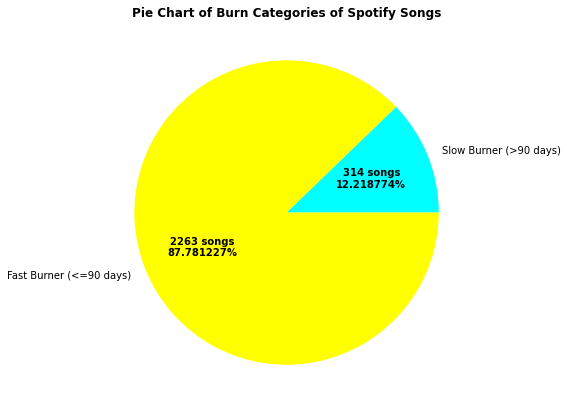

In [99]:
unique, counts = np.unique(df_song_attr_HL['half_life_class'], return_counts=True)

def getPieStat(pct, all_val_list):
    num = int(pct / 100.0 * np.sum(all_val_list))
    return '{:d} songs\n{:f}%'.format(num, pct)

fig, ax = plt.subplots(figsize=(8, 7))
pie_lbl = ['Slow Burner (>90 days)', 'Fast Burner (<=90 days)']
colours = {'cyan', 'yellow'}
wedges, texts, autotexts = ax.pie(counts, autopct=lambda pct:getPieStat(pct,counts), labels=pie_lbl, colors=colours)

plt.setp(autotexts, size=10, weight='bold')
ax.set_title("Pie Chart of Burn Categories of Spotify Songs", weight='bold')
plt.show()

### Further cleaning of data

In [100]:
# Replace all rows with NaN for the groups with 0 (solo):
# It is verified that those with group class NaN are all solo artists
df_song_attr_HL['grp_class'] = df_song_attr_HL['grp_class'].replace(np.nan, 0)

# We normalise some of the columns as many of the columns are badly skewed
df_song_attr_HL['z_danceability'] = (df_song_attr_HL['danceability']-df_song_attr_HL['danceability'].mean())/df_song_attr_HL['danceability'].std()
df_song_attr_HL['z_energy'] = (df_song_attr_HL['energy']-df_song_attr_HL['energy'].mean())/df_song_attr_HL['energy'].std()
df_song_attr_HL['z_key'] = (df_song_attr_HL['key']-df_song_attr_HL['key'].mean())/df_song_attr_HL['key'].std()
df_song_attr_HL['z_loudness'] = (df_song_attr_HL['loudness']-df_song_attr_HL['loudness'].mean())/df_song_attr_HL['loudness'].std()
df_song_attr_HL['z_speechiness'] = (df_song_attr_HL['speechiness']-df_song_attr_HL['speechiness'].mean())/df_song_attr_HL['speechiness'].std()
df_song_attr_HL['z_acousticness'] = (df_song_attr_HL['acousticness']-df_song_attr_HL['acousticness'].mean())/df_song_attr_HL['acousticness'].std()
df_song_attr_HL['z_instrumentalness'] = (df_song_attr_HL['instrumentalness']-df_song_attr_HL['instrumentalness'].mean())/df_song_attr_HL['instrumentalness'].std()
df_song_attr_HL['z_liveness'] = (df_song_attr_HL['liveness']-df_song_attr_HL['liveness'].mean())/df_song_attr_HL['liveness'].std()
df_song_attr_HL['z_valence'] = (df_song_attr_HL['valence']-df_song_attr_HL['valence'].mean())/df_song_attr_HL['valence'].std()
df_song_attr_HL['z_tempo'] = (df_song_attr_HL['tempo']-df_song_attr_HL['tempo'].mean())/df_song_attr_HL['tempo'].std()
df_song_attr_HL['duration_s'] = df_song_attr_HL['duration_ms']/1000
df_song_attr_HL['z_duration_s'] = (df_song_attr_HL['duration_s']-df_song_attr_HL['duration_s'].mean())/df_song_attr_HL['duration_s'].std()

# Finally for presentatbility, set the "primary key" (track_id) to be the
# index feature
df_song_attr_HL.set_index('track_id')

df_song_attr_HL

,track_id,track,artist,genre,all_markets,danceability,energy,key,loudness,mode,...,z_key,z_loudness,z_speechiness,z_acousticness,z_instrumentalness,z_liveness,z_valence,z_tempo,duration_s,z_duration_s
0,spotify:track:000xQL6tZNLJzIrtIgxqSl,Still Got Time (feat. PARTYNEXTDOOR),ZAYN,pop,1,0.748,0.627,7,-6.029,1,...,0.489674,0.167944,-0.553011,-0.405906,-0.160723,-0.695975,0.232166,-0.013434,188.491,-0.354247
5,spotify:track:00Blm7zeNqgYLPtW6zg8cj,One Right Now (with The Weeknd),Post Malone,rap,1,0.687,0.781,1,-4.806,1,...,-1.147301,0.666503,-0.644233,-0.792857,-0.160723,-0.766369,0.970938,-0.827238,193.507,-0.254694
11,spotify:track:00ko9WaS4jOX1kEk3gvHjf,Hot Shower,Chance the Rapper,rap,1,0.899,0.509,9,-8.040,1,...,1.035333,-0.651846,2.151030,-0.933652,-0.160723,-0.898450,0.570019,0.973297,225.924,0.388691
12,spotify:track:00lNx0OcTJrS3MKHcB80HY,You Don't Know Me - Radio Edit,Jax Jones,pop,0,0.876,0.669,11,-6.054,0,...,1.580991,0.157752,0.067136,-0.275427,-0.160723,0.028290,0.943910,0.090003,213.947,0.150982
17,spotify:track:017PF4Q3l4DBUiWoXk4OWT,Break My Heart,Dua Lipa,pop,0,0.730,0.729,4,-3.434,0,...,-0.328813,1.225803,-0.347969,-0.259117,-0.160705,1.218465,-0.024603,-0.283649,221.820,0.307238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7648,spotify:track:7ytR5pFWmSjzHJIeQkgog4,ROCKSTAR (feat. Roddy Ricch),DaBaby,north,1,0.746,0.690,11,-7.956,1,...,1.580991,-0.617603,0.284731,0.067080,-0.160723,-0.581312,0.110539,-1.066360,181.733,-0.488374
7649,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,Broccoli (feat. Lil Yachty),Shelley FKA DRAM,rap,0,0.886,0.525,8,-7.390,1,...,0.762504,-0.386872,0.008553,0.022228,-0.160723,-0.900627,1.061032,0.837001,225.205,0.374421
7650,spotify:track:7z4xW9WY86uH3gd1V9pfCM,JUGGERNAUT (feat. Lil Uzi Vert & Pharrell Will...,"Tyler, The Creator",hip,1,0.827,0.571,11,-7.949,1,...,1.580991,-0.614750,1.975280,-0.860543,-0.160723,-0.109596,0.664618,0.702573,146.419,-1.189256
7654,spotify:track:7zLMYtNJcabv4h4wBnjNQI,M3tamorphosis (feat. Kid Cudi),Playboi Carti,atl,1,0.657,0.604,0,-6.045,1,...,-1.420130,0.161421,-0.774790,-0.853203,-0.160723,-0.182168,-1.578727,-1.611547,312.257,2.102154


In [101]:
# The list of genres that exist:
genres = df_song_attr_HL['genre']
print(np.unique(genres))
print(len(np.unique(genres)))

['a' 'adult' 'afro' 'alt' 'alternative' 'arrocha' 'atl' 'aussietronica'
 'australian' 'banda' 'basshall' 'bedroom' 'boy' 'brazilian' 'broadway'
 'brooklyn' 'brostep' 'cali' 'canadian' 'celtic' 'chicago' 'chill'
 'colombian' 'concurso' 'contemporary' 'country' 'dance' 'dark' 'dembow'
 'downtempo' 'drill' 'dutch' 'edm' 'electro' 'electropop' 'emo' 'escape'
 'eurodance' 'europop' 'eurovision' 'florida' 'french' 'funk' 'german'
 'ghanaian' 'grime' 'hip' 'hollywood' 'house' 'hyperpop' 'indie' 'israeli'
 'italian' 'jawaiian' 'k-pop' 'k-rap' 'kids' 'latin' 'lgbtq+' 'lo-fi'
 'london' 'melodic' 'memphis' 'metal' 'mexican' 'miami' 'modern' 'musica'
 'neo' 'new' 'north' 'nyc' 'nz' 'ohio' 'others' 'permanent' 'piano' 'pop'
 'puerto' 'r&b' 'rap' 'reggaeton' 'rock' 'scandipop' 'sertanejo' 'slap'
 'soul' 'spanish' 'trap' 'tropical' 'uk' 'urbano' 'venezuelan' 'viral' 'z']
95


In [102]:
df_song_attr_HL[['danceability', 'energy', 'key', 
                 'loudness', 'speechiness', 'acousticness', 
                 'instrumentalness', 'liveness', 'valence', 'tempo', 
                 'duration_s']].describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s
count,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000
mean,0.682546,0.625300,5.205198,-6.440978,0.129978,0.230549,0.012169,0.181102,0.472462,121.358350,206.339770
std,0.141056,0.163167,3.665297,2.453068,0.119488,0.245251,0.075715,0.137795,0.221990,29.428471,50.385106
min,0.153000,0.005430,0.000000,-25.166000,0.023200,0.000031,0.000000,0.021500,0.032000,57.967000,30.133000
25%,0.597000,0.524000,1.000000,-7.538250,0.045500,0.040225,0.000000,0.098600,0.305000,97.014000,177.553500
50%,0.698000,0.637000,5.000000,-6.104500,0.077600,0.137000,0.000000,0.125500,0.468500,119.964500,202.476500
75%,0.782000,0.744000,8.000000,-4.823000,0.180750,0.340000,0.000034,0.219000,0.643750,142.052000,228.257000
max,0.974000,0.978000,11.000000,-0.515000,0.966000,0.993000,0.927000,0.970000,0.977000,212.117000,690.732000


<a id="section_3"></a>
## Performing the K-Means to Group Songs by "Type" Based on Music Attributes

We will first use K-Means to determine which features can most accurately split the songs into three clusters, by `half_life_class` as accurately as possible.

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# The objective is to use the music elements of the tracks hopefully 
# categorise the tracks to genre groups in hopes of reducing dimensionality
# if we are to still use the genre as a factor.

# We note that the columns were chosen such that categorial features
# and the duration are all removed.
km_columns = ['z_danceability', 'z_energy', 'z_key', 
           'z_loudness', 'z_speechiness', 'z_acousticness',
           'z_instrumentalness', 'z_liveness', 'z_valence', 'z_tempo']
df_km = df_song_attr_HL[km_columns]

df_km.head()

,z_danceability,z_energy,z_key,z_loudness,z_speechiness,z_acousticness,z_instrumentalness,z_liveness,z_valence,z_tempo
0,0.464027,0.010421,0.489674,0.167944,-0.553011,-0.405906,-0.160723,-0.695975,0.232166,-0.013434
5,0.031575,0.954242,-1.147301,0.666503,-0.644233,-0.792857,-0.160723,-0.766369,0.970938,-0.827238
11,1.534524,-0.712766,1.035333,-0.651846,2.151030,-0.933652,-0.160723,-0.898450,0.570019,0.973297
12,1.371468,0.267827,1.580991,0.157752,0.067136,-0.275427,-0.160723,0.028290,0.943910,0.090003
17,0.336418,0.635549,-0.328813,1.225803,-0.347969,-0.259117,-0.160705,1.218465,-0.024603,-0.283649


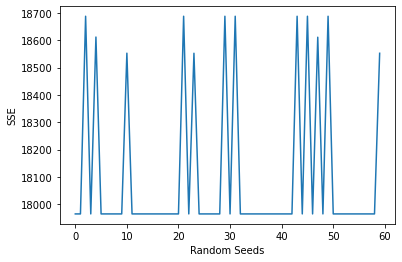

In [158]:
# Check the results across different random seeds
wcss = []
mini = 9e16
min_i = -1
for i in range(0,60):
    k_means = KMeans(n_clusters=4, init='k-means++', random_state=i)
    k_means.fit(df_km)
    if k_means.inertia_ < mini:
        mini = k_means.inertia_
        min_i = i
    wcss.append(k_means.inertia_)

# Plot curve
plt.plot(np.arange(0,60), wcss)
plt.xlabel('Random Seeds')
plt.ylabel('SSE')
plt.show()

In [159]:
print("Best random_state = ", min_i)

Best random_state =  1


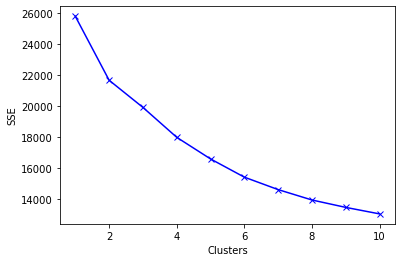

In [106]:
# Elbow method to determine optimum number of clusters
wcss_elbow = []
for i in range(1,11):
    k_means = KMeans(n_clusters=i, init='k-means++', random_state=min_i)
    k_means.fit(df_km)
    wcss_elbow.append(k_means.inertia_)

# Plot Elbow curve
plt.plot(np.arange(1,11), wcss_elbow, 'bx-')
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

In [107]:
# Confirming the elbow point
from kneed import KneeLocator
kl = KneeLocator(range(1, 11), wcss_elbow, curve="convex", direction="decreasing")
print("Optimal num of clusters =", kl.elbow)

Optimal num of clusters = 4


In [108]:
# This table is to retrieve the original song information within the clusters later
df_ori_song_info = df_song_attr_HL[['track', 'artist', 'genre', 'danceability', 'energy', 'key',  'loudness', 'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence', 'tempo', 'half_life_class']]

In [109]:
# Analyse the centroids of each cluster:
cen_list = []
km_spotify = []
df_clust_res = {}

while(True):
    km_spotify = KMeans(n_clusters=4, init='k-means++', random_state=36)
    y_km = km_spotify.fit_predict(df_km)
    df_km['cluster'] = y_km
    centroids = km_spotify.cluster_centers_

    cen_list = []
    labels = df_km.columns
    for cen in centroids:
        row = {}
        for i in range(len(labels)-1):
            row[labels[i]] = cen[i]
        cen_list.append(row)

    df_clust_res = {}
    num_tracks = []
    for i in range(len(centroids)):
        cluster = df_km.loc[df_km['cluster'] == i].copy().drop(['cluster'], axis = 1)
        df_clust = cluster.join(df_ori_song_info)
        df_clust_res[i] = df_clust.copy().drop(columns=km_columns)
        num_tracks.append(len(df_clust_res[i]))
    
    # Ensure every run of the notebook produces the same result so that it is consistent with the written details
    if num_tracks[0] > 500 and num_tracks[1] > 1000:
        break

df_centroid = pd.DataFrame(cen_list)
    
# For better interpretability, we can "un-normalise" the centroids
df_centroid['danceability'] = df_centroid['z_danceability']*df_song_attr_HL['danceability'].std()+df_song_attr_HL['danceability'].mean()
df_centroid['energy'] = df_centroid['z_energy']*df_song_attr_HL['energy'].std()+df_song_attr_HL['energy'].mean()
df_centroid['key'] = df_centroid['z_key']*df_song_attr_HL['key'].std()+df_song_attr_HL['key'].mean()
df_centroid['loudness'] = df_centroid['z_loudness']*df_song_attr_HL['loudness'].std()+df_song_attr_HL['loudness'].mean()
df_centroid['speechiness'] = df_centroid['z_speechiness']*df_song_attr_HL['speechiness'].std()+df_song_attr_HL['speechiness'].mean()
df_centroid['acousticness'] = df_centroid['z_acousticness']*df_song_attr_HL['acousticness'].std()+df_song_attr_HL['acousticness'].mean()
df_centroid['instrumentalness'] = df_centroid['z_instrumentalness']*df_song_attr_HL['instrumentalness'].std()+df_song_attr_HL['instrumentalness'].mean()
df_centroid['liveness'] = df_centroid['z_liveness']*df_song_attr_HL['liveness'].std()+df_song_attr_HL['liveness'].mean()
df_centroid['valence'] = df_centroid['z_valence']*df_song_attr_HL['valence'].std()+df_song_attr_HL['valence'].mean()
df_centroid['tempo'] = df_centroid['z_tempo']*df_song_attr_HL['tempo'].std()+df_song_attr_HL['tempo'].mean()
df_centroid['num_tracks'] = num_tracks

df_centroid = df_centroid.copy().drop(columns=km_columns)
df_centroid

C:\Users\Leonard\AppData\Local\Temp\ipykernel_20468\504388652.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_km['cluster'] = y_km


,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,num_tracks
0,0.750551,0.624260,5.789207,-6.570865,0.303425,0.174252,0.002771,0.216649,0.498580,129.642044,593
1,0.696020,0.695807,5.008180,-5.396278,0.077032,0.141256,0.002294,0.171144,0.517509,119.949109,1467
2,0.564677,0.422375,5.173913,-9.205429,0.082248,0.562567,0.011640,0.167984,0.312681,116.008919,483
3,0.592171,0.488000,4.000000,-9.878714,0.069166,0.345167,0.592629,0.177243,0.346806,113.898400,35


In [110]:
# For comparison
df_song_attr_HL[['danceability', 'energy', 'key', 
                 'loudness', 'speechiness', 'acousticness', 
                 'instrumentalness', 'liveness', 'valence', 'tempo']].describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000
mean,0.682546,0.625300,5.205198,-6.440978,0.129978,0.230549,0.012169,0.181102,0.472462,121.358350
std,0.141056,0.163167,3.665297,2.453068,0.119488,0.245251,0.075715,0.137795,0.221990,29.428471
min,0.153000,0.005430,0.000000,-25.166000,0.023200,0.000031,0.000000,0.021500,0.032000,57.967000
25%,0.597000,0.524000,1.000000,-7.538250,0.045500,0.040225,0.000000,0.098600,0.305000,97.014000
50%,0.698000,0.637000,5.000000,-6.104500,0.077600,0.137000,0.000000,0.125500,0.468500,119.964500
75%,0.782000,0.744000,8.000000,-4.823000,0.180750,0.340000,0.000034,0.219000,0.643750,142.052000
max,0.974000,0.978000,11.000000,-0.515000,0.966000,0.993000,0.927000,0.970000,0.977000,212.117000


Based on the centroid information above from the four clusters otained from the above, we can interpret the nature of the songs in each cluster:
* **Cluster 0**: The tracks have significantly higher than average danceability, key, speechiness, liveness and tempo. These songs, based on their attributes, will likely be commonly used for dancing and can be termed as "clubbing music".
* **Cluster 1**: A large majority of tracks belong to this category. These are tracks with near average danceability, energy, key, liveness and tempo. The tracks are of lower than average loudness, speechiness, acousticness, instrumentalness, and a higher than average valence. These tracks will be your generic songs which we may hear most of the time on radio or television.
* **Cluster 2**: The tracks have significantly lower than average danceability, energy, loudness, speechiness, liveness and valence. However, they have higher than average (or near average) acousticness (significant), tempo and instrumentalness. Songs in this category would be significantly instrumental in nature (more acoustic)
* **Cluster 3**: A very small number of songs belong to this category which have lower than average danceability, energy, key, loudness, speechiness, liveness, valence and tempo but are higher than average on acousticness, instrumentalness (significant). Songs in this category are likely to have no little to no vocals and may not be as instrumental (more instrumentalness and not so acoustic)

In [111]:
df_clust_res[0]

,track,artist,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,half_life_class
11,Hot Shower,Chance the Rapper,rap,0.899,0.509,9,-8.040,0.387,0.00157,0.000000,0.0573,0.599,150.001,1
19,CHopstix (with Travis Scott),ScHoolboy Q,rap,0.958,0.600,9,-6.996,0.118,0.03910,0.000000,0.2740,0.607,127.933,1
42,Woah,Lil Baby,atl,0.883,0.599,11,-5.551,0.248,0.01770,0.000000,0.1790,0.413,142.976,1
88,Free Smoke,Drake,canadian,0.736,0.491,10,-6.892,0.439,0.06810,0.000000,0.5710,0.203,141.979,1
93,Demons (feat. Fivio Foreign & Sosa Geek),Drake,canadian,0.543,0.766,0,-3.387,0.343,0.42300,0.000000,0.1550,0.729,106.869,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7622,The Greatest (feat. Kendrick Lamar),Sia,australian,0.668,0.725,1,-6.127,0.266,0.01020,0.000479,0.0561,0.729,191.944,1
7624,Wow.,Post Malone,rap,0.829,0.539,11,-7.359,0.208,0.13600,0.000002,0.1030,0.388,99.960,0
7649,Broccoli (feat. Lil Yachty),Shelley FKA DRAM,rap,0.886,0.525,8,-7.390,0.131,0.23600,0.000000,0.0570,0.708,145.990,1
7650,JUGGERNAUT (feat. Lil Uzi Vert & Pharrell Will...,"Tyler, The Creator",hip,0.827,0.571,11,-7.949,0.366,0.01950,0.000000,0.1660,0.620,142.034,1


In [112]:
np.unique(df_clust_res[0]['genre'])

array(['alternative', 'arrocha', 'atl', 'australian', 'banda',
       'brazilian', 'brooklyn', 'cali', 'canadian', 'chicago', 'dance',
       'dembow', 'drill', 'emo', 'french', 'funk', 'german', 'grime',
       'hip', 'israeli', 'italian', 'k-pop', 'kids', 'latin', 'lgbtq+',
       'london', 'melodic', 'memphis', 'miami', 'neo', 'north', 'ohio',
       'others', 'pop', 'puerto', 'r&b', 'rap', 'reggaeton', 'rock',
       'sertanejo', 'trap', 'uk'], dtype=object)

In [113]:
df_clust_res[1]

,track,artist,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,half_life_class
0,Still Got Time (feat. PARTYNEXTDOOR),ZAYN,pop,0.748,0.627,7,-6.029,0.0639,0.13100,0.000000,0.0852,0.524,120.963,1
5,One Right Now (with The Weeknd),Post Malone,rap,0.687,0.781,1,-4.806,0.0530,0.03610,0.000000,0.0755,0.688,97.014,1
12,You Don't Know Me - Radio Edit,Jax Jones,pop,0.876,0.669,11,-6.054,0.1380,0.16300,0.000000,0.1850,0.682,124.007,1
17,Break My Heart,Dua Lipa,pop,0.730,0.729,4,-3.434,0.0884,0.16700,0.000001,0.3490,0.467,113.011,0
34,One Last Song,Sam Smith,pop,0.672,0.530,1,-6.430,0.0284,0.36700,0.000000,0.3210,0.485,103.326,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7635,Stupid Love,Lady Gaga,pop,0.680,0.825,8,-4.296,0.0702,0.00173,0.000122,0.2700,0.784,117.987,1
7639,Praise The Lord (Da Shine) (feat. Skepta),A$AP Rocky,hip,0.854,0.569,5,-8.151,0.1060,0.06090,0.081600,0.1000,0.294,80.015,0
7645,KOD,J. Cole,hip,0.823,0.783,0,-6.274,0.1540,0.21000,0.000000,0.1130,0.199,141.882,1
7648,ROCKSTAR (feat. Roddy Ricch),DaBaby,north,0.746,0.690,11,-7.956,0.1640,0.24700,0.000000,0.1010,0.497,89.977,1


In [114]:
np.unique(df_clust_res[1]['genre'])

array(['adult', 'afro', 'alt', 'alternative', 'arrocha', 'atl',
       'aussietronica', 'australian', 'basshall', 'bedroom', 'boy',
       'broadway', 'brooklyn', 'brostep', 'canadian', 'chill',
       'colombian', 'contemporary', 'country', 'dance', 'downtempo',
       'dutch', 'edm', 'electro', 'emo', 'escape', 'eurodance', 'europop',
       'eurovision', 'french', 'funk', 'german', 'grime', 'hip',
       'hollywood', 'house', 'hyperpop', 'indie', 'italian', 'jawaiian',
       'k-pop', 'k-rap', 'latin', 'lgbtq+', 'melodic', 'memphis', 'metal',
       'mexican', 'modern', 'musica', 'neo', 'north', 'nyc', 'nz', 'ohio',
       'others', 'permanent', 'piano', 'pop', 'puerto', 'r&b', 'rap',
       'reggaeton', 'rock', 'scandipop', 'sertanejo', 'slap', 'soul',
       'spanish', 'trap', 'tropical', 'urbano'], dtype=object)

In [115]:
df_clust_res[2]

,track,artist,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,half_life_class
23,Nothing New (feat. Phoebe Bridgers) (Taylor’s ...,Taylor Swift,pop,0.606,0.377,0,-9.455,0.0275,0.8170,0.000000,0.1540,0.446,101.960,1
27,NUMB,XXXTENTACION,emo,0.414,0.416,11,-8.024,0.0251,0.1000,0.179000,0.1310,0.196,159.910,1
37,Come Back to Earth,Mac Miller,rap,0.272,0.238,2,-12.148,0.0349,0.8900,0.009250,0.2750,0.119,83.507,1
50,Skin,Sabrina Carpenter,pop,0.557,0.457,7,-5.372,0.0335,0.4280,0.000000,0.0567,0.328,105.918,1
68,Your Power,Billie Eilish,pop,0.632,0.284,9,-14.025,0.0801,0.9320,0.000476,0.2330,0.208,129.642,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7591,Jingle Bell Rock,Bobby Helms,adult,0.754,0.424,2,-8.463,0.0363,0.6430,0.000000,0.0652,0.806,119.705,1
7593,"i hate u, i love u (feat. olivia o'brien)",Garrett Nash,pop,0.492,0.275,6,-13.400,0.3000,0.6870,0.000000,0.1010,0.180,92.600,0
7608,come out and play,Billie Eilish,pop,0.640,0.321,0,-14.604,0.0931,0.6930,0.030700,0.1140,0.177,145.045,1
7610,Lost in the Fire,Gesaffelstein,dark,0.663,0.675,2,-12.159,0.0359,0.0863,0.001330,0.1170,0.176,101.004,1


In [116]:
np.unique(df_clust_res[2]['genre'])

array(['a', 'adult', 'alt', 'alternative', 'australian', 'boy',
       'brooklyn', 'canadian', 'celtic', 'concurso', 'contemporary',
       'country', 'dark', 'dutch', 'electropop', 'emo', 'europop',
       'florida', 'funk', 'german', 'ghanaian', 'hip', 'hollywood',
       'house', 'indie', 'k-pop', 'latin', 'lgbtq+', 'lo-fi', 'melodic',
       'metal', 'musica', 'neo', 'others', 'permanent', 'pop', 'r&b',
       'rap', 'rock', 'soul', 'venezuelan', 'viral', 'z'], dtype=object)

In [117]:
df_clust_res[3]

,track,artist,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,half_life_class
426,Jonestown (Interlude),Post Malone,rap,0.380,0.454,0,-10.271,0.0362,0.755000,0.623,0.2630,0.2880,77.592,1
689,Sunset Lover,Petit Biscuit,new,0.783,0.467,6,-9.474,0.0503,0.729000,0.809,0.1090,0.2360,90.838,1
788,Chromatica II,Lady Gaga,pop,0.184,0.297,2,-14.534,0.0359,0.473000,0.893,0.5270,0.1130,75.824,1
881,Rap Saved Me (feat. Quavo),21 Savage,hip,0.845,0.399,1,-7.509,0.3120,0.005250,0.741,0.1020,0.1480,143.049,1
1577,Butter (Instrumental),BTS,k-pop,0.429,0.387,1,-7.486,0.0753,0.000178,0.802,0.1420,0.4100,109.893,1
2511,My Bad,Khalid,pop,0.577,0.578,0,-9.146,0.0907,0.547000,0.590,0.2640,0.3670,84.963,1
2935,Bad Luck,Khalid,pop,0.432,0.520,1,-5.515,0.0548,0.277000,0.371,0.1380,0.3030,164.047,1
3114,NDA,Billie Eilish,pop,0.765,0.373,8,-9.921,0.0713,0.341000,0.525,0.1120,0.5540,85.016,1
3187,Many Men,21 Savage,hip,0.635,0.793,10,-4.333,0.0322,0.000647,0.747,0.1130,0.2810,77.594,1
3188,Chromatica I,Lady Gaga,pop,0.231,0.457,6,-10.773,0.0318,0.012600,0.875,0.3270,0.0588,65.827,1


In [118]:
np.unique(df_clust_res[3]['genre'])

array(['australian', 'canadian', 'emo', 'german', 'hip', 'k-pop', 'new',
       'permanent', 'pop', 'rap', 'reggaeton', 'rock'], dtype=object)

With the above findings, we can now append use the K-Means predictions on the song groupings to obtain the genre classification. The genre classifications will be one-hot encoded and hence, there will be an additional four columns which will be added to the original dataframe.

In [119]:
clust_col = df_km['cluster']
df_song_attr_HL_type = df_song_attr_HL.copy()
df_song_attr_HL_type['type_class'] = clust_col
for i in range(len(centroids)):
    df_song_attr_HL_type['type_' + str(i)] = np.where(df_song_attr_HL_type['type_class'] == i, 1, 0)
df_song_attr_HL_type

,track_id,track,artist,genre,all_markets,danceability,energy,key,loudness,mode,...,z_liveness,z_valence,z_tempo,duration_s,z_duration_s,type_class,type_0,type_1,type_2,type_3
0,spotify:track:000xQL6tZNLJzIrtIgxqSl,Still Got Time (feat. PARTYNEXTDOOR),ZAYN,pop,1,0.748,0.627,7,-6.029,1,...,-0.695975,0.232166,-0.013434,188.491,-0.354247,1,0,1,0,0
5,spotify:track:00Blm7zeNqgYLPtW6zg8cj,One Right Now (with The Weeknd),Post Malone,rap,1,0.687,0.781,1,-4.806,1,...,-0.766369,0.970938,-0.827238,193.507,-0.254694,1,0,1,0,0
11,spotify:track:00ko9WaS4jOX1kEk3gvHjf,Hot Shower,Chance the Rapper,rap,1,0.899,0.509,9,-8.040,1,...,-0.898450,0.570019,0.973297,225.924,0.388691,0,1,0,0,0
12,spotify:track:00lNx0OcTJrS3MKHcB80HY,You Don't Know Me - Radio Edit,Jax Jones,pop,0,0.876,0.669,11,-6.054,0,...,0.028290,0.943910,0.090003,213.947,0.150982,1,0,1,0,0
17,spotify:track:017PF4Q3l4DBUiWoXk4OWT,Break My Heart,Dua Lipa,pop,0,0.730,0.729,4,-3.434,0,...,1.218465,-0.024603,-0.283649,221.820,0.307238,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7648,spotify:track:7ytR5pFWmSjzHJIeQkgog4,ROCKSTAR (feat. Roddy Ricch),DaBaby,north,1,0.746,0.690,11,-7.956,1,...,-0.581312,0.110539,-1.066360,181.733,-0.488374,1,0,1,0,0
7649,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,Broccoli (feat. Lil Yachty),Shelley FKA DRAM,rap,0,0.886,0.525,8,-7.390,1,...,-0.900627,1.061032,0.837001,225.205,0.374421,0,1,0,0,0
7650,spotify:track:7z4xW9WY86uH3gd1V9pfCM,JUGGERNAUT (feat. Lil Uzi Vert & Pharrell Will...,"Tyler, The Creator",hip,1,0.827,0.571,11,-7.949,1,...,-0.109596,0.664618,0.702573,146.419,-1.189256,0,1,0,0,0
7654,spotify:track:7zLMYtNJcabv4h4wBnjNQI,M3tamorphosis (feat. Kid Cudi),Playboi Carti,atl,1,0.657,0.604,0,-6.045,1,...,-0.182168,-1.578727,-1.611547,312.257,2.102154,1,0,1,0,0


In [120]:
# df_song_attr_HL_type.to_csv('spotify200_songAttr_wType.csv', index = False)

<a id="section_4"></a>
## Performing the Regression and Predictive Analysis

### Binary Logistics Regression - Fast vs Slow

This section focuses on the interpretation of predictors with respect to the half-life classification (fast (1) vs slow (0)). 

In [121]:
# Import the file in the form of a dataframe if needed:
# df_song_attr_HL_type = pd.read_csv('./data/spotify200_songAttr_wType.csv')

In [122]:
# Rechecking the columns we have in the dataframe so far:
# df_song_attr_HL_type = df_song_attr_HL_type.drop(columns='genre_idx')
df_song_attr_HL_type.columns

Index(['track_id', 'track', 'artist', 'genre', 'all_markets', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'grp_class', 'half_life', 'half_life_class',
       'z_danceability', 'z_energy', 'z_key', 'z_loudness', 'z_speechiness',
       'z_acousticness', 'z_instrumentalness', 'z_liveness', 'z_valence',
       'z_tempo', 'duration_s', 'z_duration_s', 'type_class', 'type_0',
       'type_1', 'type_2', 'type_3'],
      dtype='object')

In [123]:
omitted_features = ['track_id', 'track', 'artist', 'genre', 'type_class', 'duration_ms', 'half_life']
music_type_attr = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness',  
                   'instrumentalness', 'liveness', 'valence', 'tempo']
z_music_type_attr = km_columns
reg_features = ['all_markets', 'grp_class', 'time_signature', 'mode', 'z_duration_s']
type_features = ['type_0', 'type_1', 'type_2', 'type_3']
y_bin_feature = ['half_life_class']

df_bin_reg = df_song_attr_HL_type[reg_features + type_features + y_bin_feature]
df_bin_reg

,all_markets,grp_class,time_signature,mode,z_duration_s,type_0,type_1,type_2,type_3,half_life_class
0,1,0.0,4,1,-0.354247,0,1,0,0,1
5,1,0.0,4,1,-0.254694,0,1,0,0,1
11,1,0.0,4,1,0.388691,1,0,0,0,1
12,0,0.0,4,0,0.150982,0,1,0,0,1
17,0,0.0,4,0,0.307238,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7648,1,0.0,4,1,-0.488374,0,1,0,0,1
7649,0,0.0,4,1,0.374421,1,0,0,0,1
7650,1,0.0,4,1,-1.189256,1,0,0,0,1
7654,1,0.0,4,1,2.102154,0,1,0,0,1


Below, we use a Generalised Linear Model (GLM) with the logit link function to classify songs between fast burners (1) or slow/average burners (0). As a recall, the formula is as follows:

$$ \log \frac{p}{1-p} = \beta_0 + \beta_1 X_1 + ... + \beta_k X_k $$

The results are shown below:

In [124]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix

X = df_bin_reg[reg_features + type_features]
y = df_bin_reg[y_bin_feature]

X_smLR = sm.add_constant(X, prepend = False)
X_train, X_test, y_train, y_test = train_test_split(X_smLR, y, test_size=0.2, random_state=1)
logit_model = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        half_life_class   No. Observations:                 2062
Model:                            GLM   Df Residuals:                     2053
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -738.66
Date:                Sat, 02 Apr 2022   Deviance:                       1477.3
Time:                        17:25:33   Pearson chi2:                 2.06e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.008737
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
all_markets        0.0942      0.138      0.683      0.495      -0.176       0.364
grp_class          0.0445      0.194      0.229      0.819      -0.336       0.425
time_signature    -0.3032      0.304     -0.998      0.318      -0.899       0.292
mode               0.0781      0.139      0.563      0.573      -0.194       0.350
z_duration_s      -0.0099      0.072     -0.137      0.891      -0.152       0.132
type_0             0.6716      0.325      2.069      0.039       0.035       1.308
type_1             0.2040      0.304      0.670      0.503      -0.392       0.800
type_2             0.8556      0.319      2.681      0.007       0.230       1.481
type_3             0.9751      0.630      1.549      0.121      -0.259       2.209
const              2.7063      0.979      2.763      0.006       0.787       4.626
==================================================================================
"""

In [125]:
coeff = logit_model.params
columns = X_smLR.columns
for col in X_smLR.columns:
    odds = np.exp(coeff[col])
    p = odds / (1 + odds)
    print(col + ": odds " + str(odds) + " and p = " + str(p))

all_markets: odds 1.0987317809349495 and p = 0.5235217720129454
grp_class: odds 1.0455102475301468 and p = 0.5111244242323152
time_signature: odds 0.7384152087087488 and p = 0.4247634310891844
mode: odds 1.0812394865120587 and p = 0.519517092347745
z_duration_s: odds 0.9901285961154818 and p = 0.49751990803413754
type_0: odds 1.9574169545628821 and p = 0.6618670903143571
type_1: odds 1.2262767253008384 and p = 0.55081954159815
type_2: odds 2.352746764750355 and p = 0.7017370919528843
type_3: odds 2.6513738686681094 and p = 0.7261304823970918
const: odds 14.973315917320717 and p = 0.9373955911736744


Based on the above results, we notice quite a number of features are not statistically significant. It seems as though it only matters if it is a type 2 song from the clustering done earlier. Nevertheless, we shall see what if the model is good for prediction. 

In [126]:
prob = 0.5 # We will maintain use of this probability for the classification.
log_odd = logit_model.predict(X_test)
y_prob = np.exp(log_odd) / (1 + np.exp(log_odd))
y_pred = [0 if x <= prob else 1 for x in y_prob]

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Error rate: ', (1 - accuracy_score(y_test, y_pred)))
print('F1 Score: ', f1_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Accuracy:  0.8604651162790697
Precision:  0.8604651162790697
Error rate:  0.13953488372093026
F1 Score:  0.9249999999999999
[[  0  72]
 [  0 444]]


In [127]:
pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Slow', 'Fast'], columns=['Pred_Slow', 'Pred_Fast'])

,Pred_Slow,Pred_Fast
Slow,0,72
Fast,0,444


While the F1 score is reasonable, we can still make improvements to the model and we will need to test if the model fulfills assumptions to a binary logistics regression, namely:
* **Appropriate Outcome Type**: This is already fulfilled as `half_life_class` is a binary categorical variable.
* **Absence of Multicollinearity**
* **Linearity of independent continuous variables and log-odds**
* **No strongly influential outliers**
* **Independence of observations**: Each track is a unique song which has its own independent attributes measured independently from other tracks.
* **Sufficiently large sample size**: We note that the regression is done on more than 2000 samples of training data, and hence, this is already fulfilled.

https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290

### Testing Assumptions to Binary Logistics Regression Model (Absence of Multicollinearity)

First we shall test for multicollinearity in the model. There is a concern as it is highly likely that some of the features can be correlated to the rest.

In [128]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_smLR.columns

vif_data["VIF"] = [variance_inflation_factor(X_smLR.values, i) for i in range(len(X_smLR.columns))]

vif_data

C:\Users\Leonard\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Leonard\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,feature,VIF
0,all_markets,1.014306
1,grp_class,1.035656
2,time_signature,1.026419
3,mode,1.008872
4,z_duration_s,1.016123
5,type_0,inf
6,type_1,inf
7,type_2,inf
8,type_3,inf
9,const,0.000000


We see from the above that there is quite a severe multicollinearity which happened, in particular, the type features. Hence, we will see what happens if the type feature with the highest VIF value is dropped.

In [129]:
X_improve = X_smLR.copy().drop(columns=['type_1'])

vif_data = pd.DataFrame()
vif_data["feature"] = X_improve.columns

vif_data["VIF"] = [variance_inflation_factor(X_improve.values, i) for i in range(len(X_improve.columns))]

vif_data

,feature,VIF
0,all_markets,1.014306
1,grp_class,1.035656
2,time_signature,1.026419
3,mode,1.008872
4,z_duration_s,1.016123
5,type_0,1.105321
6,type_2,1.122144
7,type_3,1.020783
8,const,206.865527


In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_improve, y, test_size=0.2, random_state=1)
logit2_model = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
logit2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        half_life_class   No. Observations:                 2062
Model:                            GLM   Df Residuals:                     2053
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -738.66
Date:                Sat, 02 Apr 2022   Deviance:                       1477.3
Time:                        17:25:33   Pearson chi2:                 2.06e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.008737
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
all_markets        0.0942      0.138      0.683      0.495      -0.176       0.364
grp_class          0.0445      0.194      0.229      0.819      -0.336       0.425
time_signature    -0.3032      0.304     -0.998      0.318      -0.899       0.292
mode               0.0781      0.139      0.563      0.573      -0.194       0.350
z_duration_s      -0.0099      0.072     -0.137      0.891      -0.152       0.132
type_0             0.4676      0.177      2.648      0.008       0.121       0.814
type_2             0.6516      0.213      3.057      0.002       0.234       1.069
type_3             0.7711      0.739      1.043      0.297      -0.678       2.220
const              2.9103      1.223      2.380      0.017       0.514       5.307
==================================================================================
"""

In the above, we see that the `all_markets`, `grp_class`, `time_signature`, `mode`, `z_duration_s`, `type_3` features are not satistically significant at a 5% significant level. Hence, we can perform the regression again without those features:

In [131]:
X_improve = X_smLR.copy().drop(columns=['all_markets', 'mode', 'grp_class', 'time_signature', 
                                   'z_duration_s', 'type_1', 'type_3'])

X_train, X_test, y_train, y_test = train_test_split(X_improve, y, test_size=0.2, random_state=1)
logit2_model = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
logit2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        half_life_class   No. Observations:                 2062
Model:                            GLM   Df Residuals:                     2059
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -740.41
Date:                Sat, 02 Apr 2022   Deviance:                       1480.8
Time:                        17:25:33   Pearson chi2:                 2.06e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.007048
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
type_0         0.4370      0.175      2.503      0.012       0.095       0.779
type_2         0.6637      0.211      3.152      0.002       0.251       1.076
const          1.8154      0.083     21.757      0.000       1.652       1.979
==============================================================================
"""

In [132]:
coeff = logit2_model.params
columns = X_improve.columns
for col in X_improve.columns:
    odds = np.exp(coeff[col])
    p = odds / (1 + odds)
    print(col + ": odds " + str(odds) + " and p = " + str(p))

type_0: odds 1.5480278710961801 and p = 0.6075396147178748
type_2: odds 1.9419909928064856 and p = 0.6600941326995502
const: odds 6.14371257485029 and p = 0.860016764459346


Hence, in the above, we can see that the `type_0` and `type_2` features are statistically significant in explaining if a track is to be classified to be a fast-burner (1) or a slow burner (0). We can interpret the coefficients as follows:
* The baseline odds of a track being classified as a fast-burner is 6.144. (probability = 0.860).
* Being a type 0 track multiplies the odds of being classified as a fast-burner by 1.548, holding all others constant.
* Being a type 2 track multiplies the odds of being classified as a fast-burner by 1.942, holding all others constant.

In [133]:
log_odd = logit2_model.predict(X_test)
y_prob = np.exp(log_odd) / (1 + np.exp(log_odd))
y_pred = [0 if x <= prob else 1 for x in y_prob]

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Error rate: ', (1 - accuracy_score(y_test, y_pred)))
print('F1 Score: ', f1_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Accuracy:  0.8604651162790697
Precision:  0.8604651162790697
Error rate:  0.13953488372093026
F1 Score:  0.9249999999999999
[[  0  72]
 [  0 444]]


In [134]:
pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Slow', 'Fast'], columns=['Pred_Slow', 'Pred_Fast'])

,Pred_Slow,Pred_Fast
Slow,0,72
Fast,0,444


In the improved model, we note that all predictors are discrete variables and hence, we automatically assume that *Linearity of independent continuous variables and log-odds* assumption is fufilled as this assumption only applies when there are continuous features used for in the regression.

Furthermore, analysing the F1-score, we can see that the F1-score is still sufficiently high, meaning that the model is reasonable to be used for prediction. We will henceforth use the improved model to test for the other assumption.

### Testing Assumptions to Binary Logistics Regression Model (No strongly influential outliers)

We can use Cook's Distance to determin the influence of a data point. Cook's Distance, $ D_i $ of observation $ i $ is defined to be:

$$ D_i = \frac{\sum_{j=1}^{n} (\hat{y_i} - \hat{y_{j(i)}})^2}{ps^2} $$

where $ \hat{y_{j(i)}} $ is the fitted response value when excluding observation $ i $ and $ s^2 $ is the mean squared error of the regression model. Hence, it summarises the changes in the regression model when the $ i $th observation is removed. 

We will use the threshold such that if the Cook's Distance of the $ i $th is more than $ \frac{4}{\text{no. of observations}} $, then we deem that observation as influential. To determine if an observation is an outlier, we will use standardised residuals of the regression such that residual value of predicting a data point is greater than 3, we will classify it as an extreme outlier.

In [135]:
import scipy as sp

# Get influence measures
influence = logit2_model.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(X)

# Append absolute standardized residual values 
diagnosis_df['std_resid'] = sp.stats.zscore(logit2_model.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]

# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False)

C:\Users\Leonard\AppData\Local\Temp\ipykernel_20468\3143011333.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = sp.stats.zscore(logit2_model.resid_pearson)
C:\Users\Leonard\AppData\Local\Temp\ipykernel_20468\3143011333.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(lambda x: np.abs(x))


,cooks_d,std_resid
2662,0.010662,3.454133
5897,0.010662,3.454133
6571,0.010662,3.454133
6332,0.010662,3.454133
7292,0.010662,3.454133
...,...,...
6701,0.006443,3.083932
7136,0.006443,3.083932
6262,0.006443,3.083932
4240,0.006443,3.083932


We see that there are quite a number of rows which are such that the standardised residuals are more than 3 and are also influential. We will remove all rows from the original data set and reperform the binary logistics regression:

In [136]:
X_improve2 = X_improve.copy().drop(extreme.index)
y_improve2 = y.copy().drop(extreme.index)
X_train, X_test, y_train, y_test = train_test_split(X_improve2, y_improve2, test_size=0.2, random_state=1)
logit2A_model = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
logit2A_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        half_life_class   No. Observations:                 2001
Model:                            GLM   Df Residuals:                     1998
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -578.21
Date:                Sat, 02 Apr 2022   Deviance:                       1156.4
Time:                        17:25:34   Pearson chi2:                 2.00e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05070
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
type_0         2.1050      0.347      6.073      0.000       1.426       2.784
type_2         2.0298      0.367      5.534      0.000       1.311       2.749
const          1.7685      0.082     21.561      0.000       1.608       1.929
==============================================================================
"""

In [137]:
coeff = logit2A_model.params
columns = X_improve2.columns
for col in X_improve2.columns:
    odds = np.exp(coeff[col])
    p = odds / (1 + odds)
    print(col + ": odds " + str(odds) + " and p = " + str(p))

type_0: odds 8.207189542483677 and p = 0.8913892241073332
type_2: odds 7.612500000000085 and p = 0.883889695210451
const: odds 5.862068965517253 and p = 0.8542713567839199


In [138]:
log_odd = logit2A_model.predict(X_test)
y_prob = np.exp(log_odd) / (1 + np.exp(log_odd))
y_pred = [0 if x <= prob else 1 for x in y_prob]

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Error rate: ', (1 - accuracy_score(y_test, y_pred)))
print('F1 Score: ', f1_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9041916167664671
Precision:  0.9041916167664671
Error rate:  0.09580838323353291
F1 Score:  0.949685534591195
[[  0  48]
 [  0 453]]


In [139]:
pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Slow', 'Fast'], columns=['Pred_Slow', 'Pred_Fast'])

,Pred_Slow,Pred_Fast
Slow,0,48
Fast,0,453


In the above, we see an improvement to the F1 score as well as the accuracy and precision scores as well.

<a id="section_5"></a>
## Causality Analysis

We recall that the features utilised for the binary logistics regression were `type_0`, `type_2`. We note that as the track types are obtained by performing a K-means of the music attributes, naturally, the music attributes will be the possible instrumental variables (IVs) which will lead to the set up the 2SLS model. 

First we will need to be wise with the choice of the IVs, and hence, we will see which of the IVs are strongly correlated to the types.

In [140]:
df_CA = df_song_attr_HL_type[z_music_type_attr + type_features]
df_CA = df_CA.drop(extreme.index)
y_CA = df_song_attr_HL_type['half_life_class']
y_CA = y_CA.drop(extreme.index)

corr = df_CA.corr()
corr.style.background_gradient(cmap='coolwarm')

,z_danceability,z_energy,z_key,z_loudness,z_speechiness,z_acousticness,z_instrumentalness,z_liveness,z_valence,z_tempo,type_0,type_1,type_2,type_3
z_danceability,1.000000,0.111140,0.037201,0.187535,0.180929,-0.286373,-0.096679,-0.101253,0.317943,-0.048377,0.252631,0.117835,-0.398175,-0.075995
z_energy,0.111140,1.000000,0.031566,0.724075,-0.005893,-0.515836,-0.134935,0.104833,0.392253,0.087882,-0.012208,0.500359,-0.595269,-0.101888
z_key,0.037201,0.031566,1.000000,-0.001806,0.045059,0.003450,-0.021526,0.000550,0.057639,-0.011344,0.080716,-0.053764,-0.006163,-0.038190
z_loudness,0.187535,0.724075,-0.001806,1.000000,-0.085653,-0.460398,-0.214522,0.020184,0.327253,0.042741,-0.036816,0.496306,-0.543650,-0.167739
z_speechiness,0.180929,-0.005893,0.045059,-0.085653,1.000000,-0.040889,-0.065564,0.135764,0.057911,0.108648,0.795693,-0.511653,-0.180943,-0.059056
z_acousticness,-0.286373,-0.515836,0.003450,-0.460398,-0.040889,1.000000,0.091723,-0.019294,-0.124261,-0.081233,-0.121981,-0.421170,0.651368,0.057658
z_instrumentalness,-0.096679,-0.134935,-0.021526,-0.214522,-0.065564,0.091723,1.000000,-0.002744,-0.110628,-0.025138,-0.067442,-0.157664,-0.000531,0.900081
z_liveness,-0.101253,0.104833,0.000550,0.020184,0.135764,-0.019294,-0.002744,1.000000,0.001681,0.002653,0.146332,-0.084965,-0.047283,-0.003185
z_valence,0.317943,0.392253,0.057639,0.327253,0.057911,-0.124261,-0.110628,0.001681,1.000000,0.018338,0.058415,0.234920,-0.342046,-0.068127
z_tempo,-0.048377,0.087882,-0.011344,0.042741,0.108648,-0.081233,-0.025138,0.002653,0.018338,1.000000,0.147382,-0.053579,-0.080331,-0.030043


The various type features, as observed in the correlation table:
* **Case 1:** `z_energy`, `z_acousticness` are reasonably correlated to `type_2`. We ignore `z_loudness` due to its strong correlation to `z_energy`
* **Case 2:** `z_speechiness` is reasonably correlated to `type_0`

We note that due to the fact that we used are using a logistics regression, we cannot use the conventional 2SLS which uses a two-stage OLS models. Hence, we will have to manually create our own "2SLS" where both stages utilise a logistics regression due to the nature of our data.

In [141]:
def twoSLSLog(y, x_no_endog_list, endog_feature, iv_list, data):
    X_case = data[x_no_endog_list + iv_list]
    endog_case = data[endog_feature]
    X_case = sm.add_constant(X_case)
    
    case_res = sm.GLM(endog_case, X_case, family=sm.families.Binomial()).fit()
    first_stg_pred = case_res.predict()
    ftest_hypo_str = ""
    for i in range(len(iv_list) - 1):
        ftest_hypo_str += "(" + iv_list[i] + " = 0), "
    ftest_hypo_str += "(" + iv_list[len(iv_list) - 1] + " = 0)"
    ftest_hyp = case_res.f_test(ftest_hypo_str)
    
    X_tsls = data[x_no_endog_list]
    X_tsls['first_stg_pred'] = first_stg_pred
    X_tsls = sm.add_constant(X_tsls)
    
    res_tsls = sm.GLM(y, X_tsls, family=sm.families.Binomial()).fit()
    
    X_haus = X_tsls.copy()
    X_haus['stg1_resid'] = case_res.resid_response
    endog_test_res = sm.GLM(y, X_haus, family=sm.families.Binomial()).fit()
    hausTest = endog_test_res.f_test('(stg1_resid = 0)')
    
    tsls_resid_case = res_tsls.resid_response
    sargan_case = sm.OLS(tsls_resid_case, data[iv_list]).fit()
    sarganTest = sargan_case.f_test(ftest_hypo_str)
    
    if len(iv_list) == 1:
        return ftest_hyp, case_res, res_tsls, hausTest
    else:
        return ftest_hyp, case_res, res_tsls, hausTest, sarganTest
    

### Case 1: Energy and Acousticness cause fast burning

In [142]:
ftest, firststg, res_tsls, hausTest, saganTest = twoSLSLog(y_CA, ['type_0'], 'type_2', 
                                                           ['z_energy', 'z_acousticness'], df_CA)

print("Test for IV strength:", ftest)
print("Hausman-Wu endogeniety test:", hausTest)
print("Sagan overidentification test:", saganTest)

Test for IV strength: <F test: F=191.1039616365477, p=5.923426337337293e-78, df_denom=2.5e+03, df_num=2>
Hausman-Wu endogeniety test: <F test: F=16.18614505229626, p=5.9117826729816296e-05, df_denom=2.5e+03, df_num=1>
Sagan overidentification test: <F test: F=3.6428135643050497, p=0.026317640632025456, df_denom=2.5e+03, df_num=2>


C:\Users\Leonard\AppData\Local\Temp\ipykernel_20468\1298944326.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tsls['first_stg_pred'] = first_stg_pred


By the F-test for IV strength, as the p-value is small, we can say that `z_energy` and `z_acousticness` are strong candidates for IVs for `type_2`.

By the Hausman-Wu test for endogeneity, as the p-value << 0.05, we can reject the null hypothesis at a 5% significance level that `type_2` is exogenous. Thus, `type_2` is indeed endogenous with both `z_energy` and `z_acousticness` as IVs.

By the Sagan Test for overidentification, under a 5% significance level, we have have to reject the null hypothesis that `z_energy` and `z_acousticness` are exclusive exogenous IVs.

We note that if each instrument is tested independently:

In [143]:
ftest_ac, firststg_ac, res_tsls_ac, hausTest_ac = twoSLSLog(y_CA, ['type_0'], 'type_2', ['z_acousticness'], df_CA)

print("Test for IV strength:", ftest_ac)
print("Hausman-Wu endogeniety test:", hausTest_ac)

Test for IV strength: <F test: F=482.3791960051144, p=6.641369671562494e-98, df_denom=2.5e+03, df_num=1>
Hausman-Wu endogeniety test: <F test: F=26.47842974883232, p=2.8721598303952953e-07, df_denom=2.5e+03, df_num=1>


C:\Users\Leonard\AppData\Local\Temp\ipykernel_20468\1298944326.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tsls['first_stg_pred'] = first_stg_pred


By the F-test for IV strength, as the p-value is small, we can say that `z_acousticness` is a strong candidate for IVs for `type_2`.

By the Hausman-Wu test for endogeneity, as the p-value << 0.05, we can reject the null hypothesis at a 5% significance level that `type_2` is exogenous. Thus, `type_2` is indeed endogenous with `z_acousticness` as an IV.

**Hence, we can conclude that acousticness causes fast burning.**

In [144]:
res_tsls_ac.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        half_life_class   No. Observations:                 2502
Model:                            GLM   Df Residuals:                     2499
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -744.43
Date:                Sat, 02 Apr 2022   Deviance:                       1488.9
Time:                        17:25:35   Pearson chi2:                 2.47e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.03459
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.7290      0.086     20.096      0.000       1.560       1.898
type_0             2.0664      0.304      6.790      0.000       1.470       2.663
first_stg_pred     1.6336      0.335      4.872      0.000       0.976       2.291
==================================================================================
"""

In [145]:
coeff = res_tsls_ac.params
columns = ['type_0', 'first_stg_pred', 'const']
for col in columns:
    odds = np.exp(coeff[col])
    p = odds / (1 + odds)
    print(col + ": odds " + str(odds) + " and p = " + str(p))

type_0: odds 7.896668198792385 and p = 0.8875983707995609
first_stg_pred: odds 5.122354995874462 and p = 0.8366641593514508
const: odds 5.635288058135447 and p = 0.8492906425104013


In [146]:
ftest_e, firststg_e, res_tsls_e, hausTest_e = twoSLSLog(y_CA, ['type_0'], 'type_2', ['z_energy'], df_CA)

print("Test for IV strength:", ftest_e)
print("Hausman-Wu endogeniety test:", hausTest_e)

Test for IV strength: <F test: F=412.44818130486493, p=5.382673217519975e-85, df_denom=2.5e+03, df_num=1>
Hausman-Wu endogeniety test: <F test: F=19.439828165620014, p=1.0821101692228537e-05, df_denom=2.5e+03, df_num=1>


C:\Users\Leonard\AppData\Local\Temp\ipykernel_20468\1298944326.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tsls['first_stg_pred'] = first_stg_pred


By the F-test for IV strength, as the p-value is small, we can say that `z_energy` is a strong candidate for IVs for `type_2`.

By the Hausman-Wu test for endogeneity, as the p-value << 0.05, we can reject the null hypothesis at a 5% significance level that `type_2` is exogenous. Thus, `type_2` is indeed endogenous with `z_energy` as an IV.

**Hence, we can conclude that energy causes fast burning.**

In [147]:
res_tsls_e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        half_life_class   No. Observations:                 2502
Model:                            GLM   Df Residuals:                     2499
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -737.45
Date:                Sat, 02 Apr 2022   Deviance:                       1474.9
Time:                        17:25:35   Pearson chi2:                 2.51e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.03996
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.6867      0.084     20.194      0.000       1.523       1.850
type_0             2.1088      0.304      6.946      0.000       1.514       2.704
first_stg_pred     1.9933      0.349      5.704      0.000       1.308       2.678
==================================================================================
"""

In [148]:
coeff = res_tsls_e.params
columns = ['type_0', 'first_stg_pred', 'const']
for col in columns:
    odds = np.exp(coeff[col])
    p = odds / (1 + odds)
    print(col + ": odds " + str(odds) + " and p = " + str(p))

type_0: odds 8.238426122863746 and p = 0.8917564543244929
first_stg_pred: odds 7.339440330516951 and p = 0.8800878763601621
const: odds 5.4015171509667415 and p = 0.8437870310401367


Looking at the causality coefficient (the coefficient of the `first_stage_pred`), we can see that the en energy (causality odds of 7.339) increases the causality odds of a track being a fast burner much more than the acousticness (causality odds of 5.122).

### Case 2: Speechiness cause fast burning

In [149]:
ftest_s, firststg_s, res_tsls_s, hausTest_s = twoSLSLog(y_CA, ['type_2'], 'type_0', ['z_speechiness'], df_CA)

print("Test for IV strength:", ftest_s)
print("Hausman-Wu endogeniety test:", hausTest_s)

Test for IV strength: <F test: F=319.5713156472142, p=2.3553930635201498e-67, df_denom=2.5e+03, df_num=1>
Hausman-Wu endogeniety test: <F test: F=19.84092306432586, p=8.786590323352433e-06, df_denom=2.5e+03, df_num=1>


C:\Users\Leonard\AppData\Local\Temp\ipykernel_20468\1298944326.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tsls['first_stg_pred'] = first_stg_pred


In [160]:
res_tsls_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        half_life_class   No. Observations:                 2502
Model:                            GLM   Df Residuals:                     2499
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -736.51
Date:                Sat, 02 Apr 2022   Deviance:                       1473.0
Time:                        21:12:08   Pearson chi2:                 2.48e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.04068
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.7645      0.077     23.003      0.000       1.614       1.915
type_2             2.0288      0.329      6.169      0.000       1.384       2.673
first_stg_pred     1.7459      0.277      6.300      0.000       1.203       2.289
==================================================================================
"""

In [162]:
coeff = res_tsls_s.params
columns = ['type_2', 'first_stg_pred', 'const']
for col in columns:
    odds = np.exp(coeff[col])
    p = odds / (1 + odds)
    print(col + ": odds " + str(odds) + " and p = " + str(p))

type_2: odds 7.604707203567329 and p = 0.883784540677291
first_stg_pred: odds 5.730970966081277 and p = 0.8514330242933446
const: odds 5.838489084599308 and p = 0.8537688680015502


By the F-test for IV strength, as the p-value is small, we can say that `z_speechiness` is a strong candidate for IVs for `type_0`.

By the Hausman-Wu test for endogeneity, as the p-value << 0.05, we can reject the null hypothesis at a 5% significance level that `type_0` is exogenous. Thus, `type_0` is edogenous with `z_speechiness` as an IV.

**Hence, we can conclude that speechiness causes fast burning.**

<a id="section_6"></a>
## Conclusion

We looked into the daily Spotify 200 charts to retrieve information on each track's half-life, defined to be the number of days for the track to go from its peak number of streams to half its peak number of streams, and used the Spotify API to retrieve each track's attributes. 

Due to the inavailability of specific genre information of each track, and the sheer number of genres obtained by finding the most common number of words of "genres" associated to the track's associated artist and album, we used the K-means algorithm and find that the tracks can be clustered by its normalised attributes to four clusters, to which we find that two of such clusters are significant in explaining whether a track can be classified as a "fast burner", with half-life lasting at most 3 months, or a "slow-burner", with half-life lasting more than 3 months. These two clusters, can be interpreted from their centroids to be tracks which are towards being "clubbing music" with high danceability and energy, and songs which are more acoustic in nature. 

These "cluster variables" used in the binary logistics regression are tested to be endogenous. Through the use of instruments and a modified 2SLS regression to better suit a binary logistics regression, we prove that acousticness and energy to be causes of a track to be classified as a "fast-burner" or "slow-burner".

With respect to how the findings can be useful for our intended target audience and to answer the focal question on "**What factors contribute to a song being a "slow-burner" within the top-200 charts, or in other words, a long-lasting song in Spotify in the top-200 charts.**", for a track have staying power in Spotify, it should, at best, not be classified as a track which is under the cluster that is more acoustic nor the "clubbing music" cluster. In other words, it should not be so acoustic, does not have so much energy and should not have too many words.  